In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 11 10:40:31 2019

@author: bzfkostr
"""
from __future__ import division
import numpy as np
import scipy.sparse
from numpy.linalg import inv
from math import exp
from ParametersB_SIR2 import *
import matplotlib.pyplot as plt
import seaborn as sns

# FD scheme for not tau-leaping parameters, for example ParametersA,B
'''
This code returns the solution of the reaction-diffusion equation laplace u=D*u_t+r(u1,u2) with r( being the reaction function of the Lotka-Volerra equation)
, where u=(u1,u2) with homogeneous 
Neumann boundary conditions and the initial conditions at time 0 u1_0:=u1(x,0) and u2_0:=u2(x,0).
The solution is calculated witht he Finite Difference scheme and Strang Splitting. To obtain the final concentration in each cell, we average over the 4 neighbouring
grid-cells of FD. This requires only one more cell in the calculation. 
In the script we also give some possible initial condition u_0.
The skript requires:
    
Space discretization
l+1=number of grid-cells in y direction
m+1=number of grid-cells in x direction

Time discretization
deltat=time-step size
n=number of iterations 

Mathematical parameters
D1, D2=diffusion coefficients of u1 and u2
r1=first order macroscopic rate
r2_macro=second oder macroscopic rate
r3=zero reaction mmacroscopic rate
L=domain length

REMINDER:SIR equation

A+B->2B with rate r1_macro
B->0 with rate r2

A=Preys
B=Predators

'''

#%%

'Laplace Matrix with Neumann boundary conditions everywhere'

C=np.zeros((l, l))

for i in range(l):
    for j in range(l):
        if i==j:
            C[i,j]=4
        if abs(i-j)==1:
            
            C[i,j]=-1
           
C[0, 1]=-2
C[l-1, l-2]=-2            


A = scipy.sparse.bmat([[C if i == j  else -2*np.identity(l) if abs(i-j)==1
                        and j==0 and i==1 else -2*np.identity(l) if abs(i-j)==1 and j==l-1 else -np.identity(l) 
                        if abs(i-j)==1 else None for i in range(m)] for j in range(m)], format='bsr').toarray()

''' Create Solution Vector (column-wise) for preys and predators'''    
#%%


'''Iteration matrices'''


B1=inv(np.identity(int(l*m))+D1*deltat/(h**2)*A)
B2=inv(np.identity(int(l*m))+D2*deltat/(h**2)*A)
B3=inv(np.identity(int(l*m))+D3*deltat/(h**2)*A)
#%%
x=np.linspace(0,a,m+1)
y=np.linspace(0,a,l+1)


U0Prey=np.zeros(int((l)*(m)))
k=0
for i in range(m):
    for j in range(l):
        U0Prey[k]=function1(np.array([x[i], y[j]]))
        k=k+1

U0Pred=np.zeros(int((l)*(m)))
k=0
for i in range(m):
    for j in range(l):
        U0Pred[k]=function2(np.array([x[i], y[j]]))
        k=k+1
        

U0Recovered=np.zeros(int((l)*(m)))

listt=np.linspace(0, timesteps*deltat, timesteps)

U1=np.zeros(int(l*m))
listU1=[]
listU1.append(U0Prey)
U1=U0Prey

U2=np.zeros(int(l*m))
listU2=[]
listU2.append(U0Pred)
U2=U0Pred

U3=np.zeros(int(l*m))
listU3=[]
listU3.append(U0Recovered)
U3=U0Recovered

'''Strang-Splitting with RK'''

for t in range(timesteps-1):
    
    U1_temp = U1 - deltat * U2 * U1 * r1_macro * 0.5
    U2_temp = U2 + deltat * U2 * U1 * 0.5* r1_macro - r2_macro * U2 * 0.5 * deltat
    U3_temp = U3 + deltat * 0.5 * (r2_macro * U2)
    
    U1 = B1.dot(U1_temp) # full timestep
    U2 = B2.dot(U2_temp)
    U3 = B3.dot(U3_temp)
    
    U1_temp = U1 - deltat * U2 * U1 * r1_macro * 0.5
    U2_temp = U2 + deltat * U2 * U1 * 0.5* r1_macro - r2_macro * U2 * 0.5 * deltat
    U3_temp = U3 + deltat * 0.5 * (r2_macro * U2)
    
    listU1.append(U1_temp)
    listU2.append(U2_temp)
    listU3.append(U3_temp)
    
    U1 = np.copy(U1_temp)
    U2 = np.copy(U2_temp)
    U3 = np.copy(U3_temp)
    
def functionMatrix(listU):
    listM=[]
    for t in range(timesteps): 
        if t%1==0: # which time-steps you want to save
            helpM=np.zeros((l, m))
            Ut=listU[t]
            k=0
           
            for j in range(m):
                for i in range(l):
                    helpM[i,j]=Ut[k]
                    k=k+1
            M=np.zeros((l-1,m-1))
            for i in range(l-1):
                for j in range(m-1):
                    M[i,j]=(helpM[i+1,j]+helpM[i,j]+helpM[i,j+1]+helpM[i+1,j+1])/4
             
            listM.append(M)
    return listM
Prey=functionMatrix(listU1)
Pred=functionMatrix(listU2)
Recovered=functionMatrix(listU3)

np.save('./Solutions/FDSIR1_B2', Prey)
np.save('./Solutions/FDSIR2_B2', Pred)
np.save('./Solutions/FDSIR3_B2', Recovered)

	

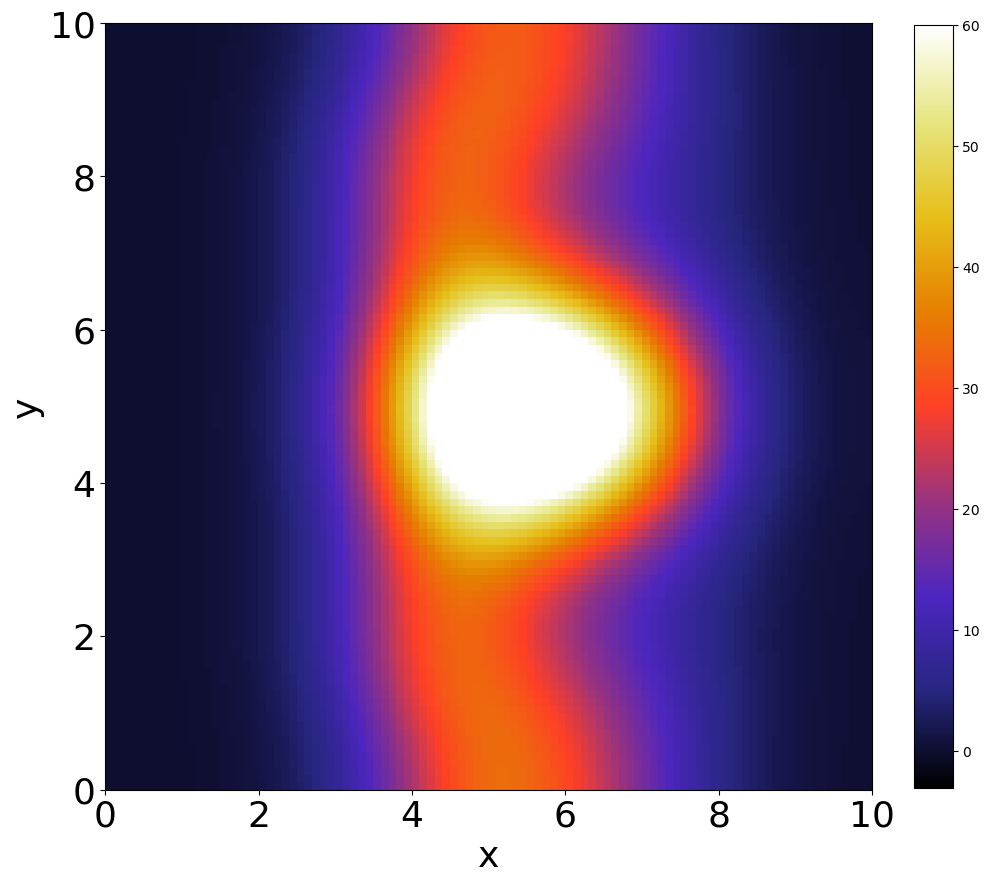

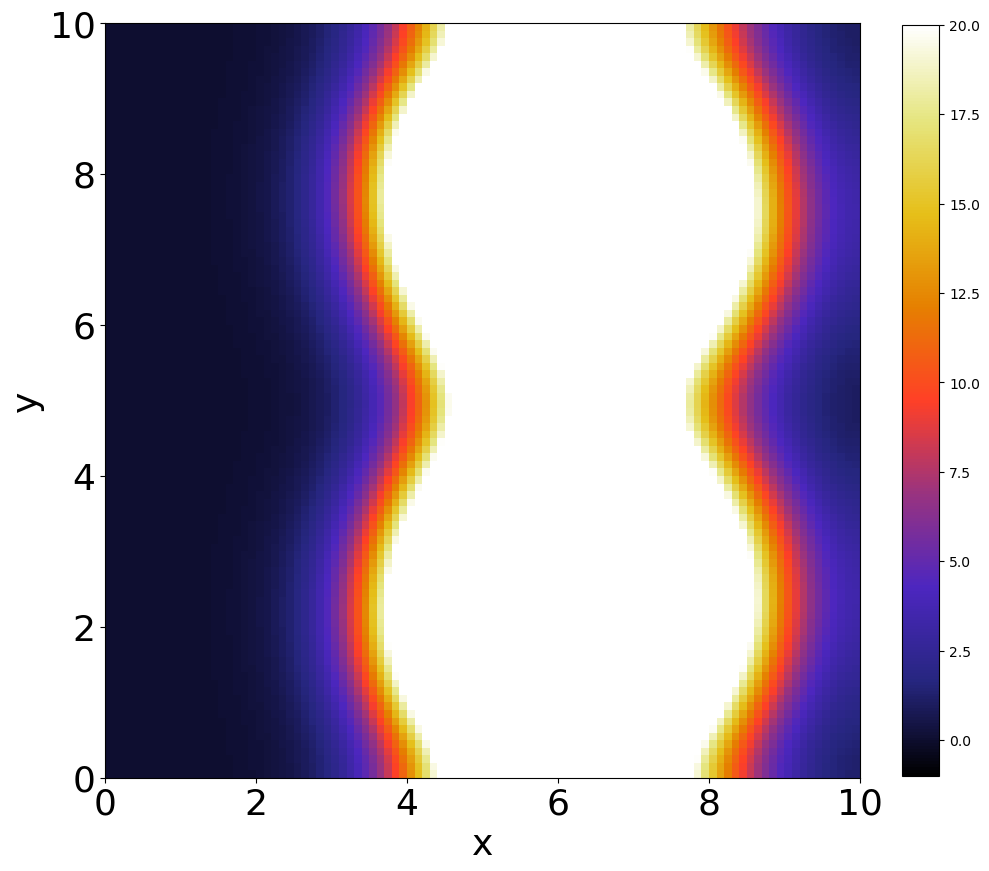

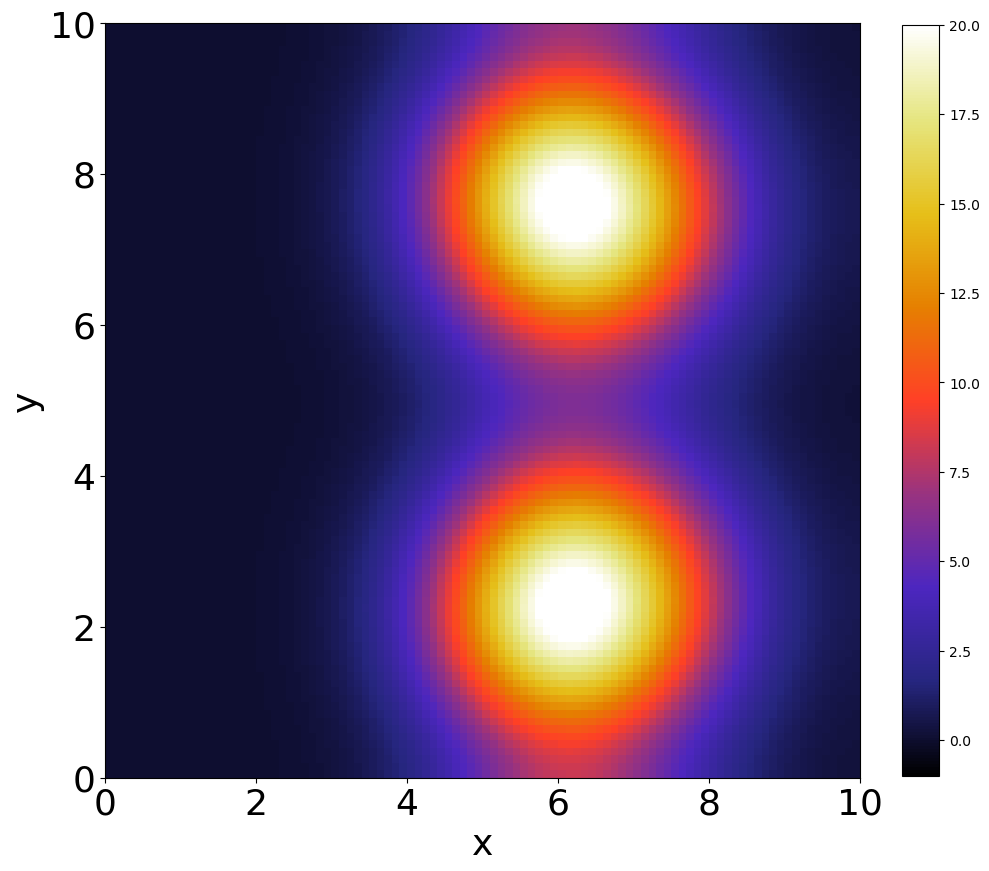

In [3]:
Max1=60
Time=200
#Time=300
a=10
Name='SIR_B2'
fig = plt.figure(figsize=(a, a))

plt.imshow(Prey[Time], interpolation='nearest', cmap='CMRmap', extent=[0, a, 0, a])
plt.colorbar(fraction=0.045)
plt.tick_params(labelsize=26)
plt.xlabel('x', fontsize=26)
plt.ylabel('y', fontsize=26)
plt.clim(-Max1/20, Max1)
plt.tight_layout()
plt.savefig('./Plots/Reaction' + str('Sus') + str(Time*deltat) + str(Name) + '.pdf')

Max2=20
fig = plt.figure(figsize=(a, a))

plt.imshow(Pred[Time], interpolation='nearest', cmap='CMRmap', extent=[0, a, 0, a])
plt.colorbar(fraction=0.045)
plt.tick_params(labelsize=26)
plt.xlabel('x', fontsize=26)
plt.ylabel('y', fontsize=26)
plt.clim(-Max2/20, Max2)
plt.tight_layout()
plt.savefig('./Plots/Reaction' + str('Inf') + str(Time*deltat) + str(Name) + '.pdf')


Max3=20

fig = plt.figure(figsize=(a, a))

plt.imshow(Recovered[Time], interpolation='nearest', cmap='CMRmap', extent=[0, a, 0, a])
plt.colorbar(fraction=0.045)
plt.tick_params(labelsize=26)
plt.xlabel('x', fontsize=26)
plt.ylabel('y', fontsize=26)
plt.clim(-Max3/20, Max3)
plt.tight_layout()
plt.savefig('./Plots/Reaction' + str('Rec') + str(Time*deltat) + str(Name) + '.pdf')

In [13]:
a=np.array([6,6])
uPrey(a)

1200